# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [6]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
# sys.path.insert(0, os.path.abspath('./forecaster_params'))
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
#matplotlib.rc("font", serif='Computer Modern Roman')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

graphdir = './'
figsize=(8,5)

## Load predictive model 

In [9]:
baseline = pd.read_pickle('forecaster_params/wind_baseline.pickle')
autoreg_residual_params = pd.read_pickle('forecaster_params/residual_params.pickle')
sigma_residual_errors = pd.read_pickle('forecaster_params/sigma_epsilon.pickle')
train = pd.read_pickle('forecaster_params/wind_power_train.pickle')
test = pd.read_pickle('forecaster_params/wind_power_test.pickle')
p_wind = pd.concat([train,test])
del train
del test

## Set constants and test period

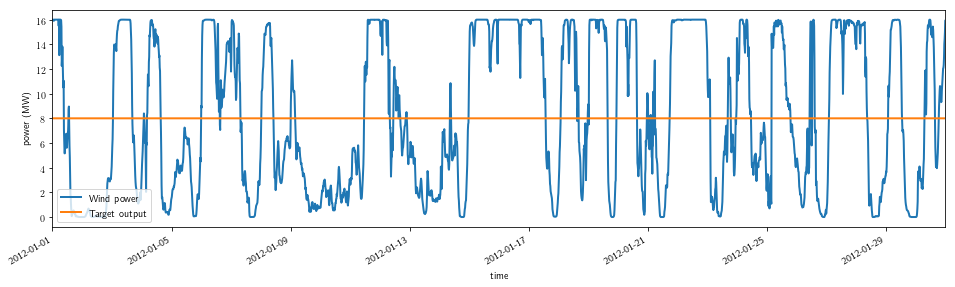

In [16]:
# CONSTANTS
storage_capacity = 100 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours
wind_power_max = 16.  # TODO delete?
wind_power_min = 0.  # TODO delete?

gas_power_max = 12  #MW
gas_power_min = 0 #MW
gas_alpha = .5
gas_beta = 40.

# len of each time interval, in hours
len_interval = (baseline.index[1] - baseline.index[0]).seconds/3600
intervals_per_day = int(24 / len_interval)

# analysis horizon
T = intervals_per_day * 31

# we test on the first off-sample month
sim_start_time = 70080 # Timestamp('2012-01-01 00:00:00')
sim_end_time = sim_start_time + T

assert len(baseline) > sim_end_time
assert baseline.index[sim_start_time].year >= 2012 # out of sample

MPC_final_energy_price = 80 / len_interval


#wind_power_available = test[target_output.index]

target_output = pd.Series(data= 8., #baseline[sim_start_time:sim_end_time].mean(),
                          index=baseline[sim_start_time:sim_start_time + 2*T].index)

#p_wind[sim_start_time:sim_end_time].plot(figsize=(12,3), label='Wind power')
plt.figure(figsize=(16,6))
plt.subplot2grid((4,1), (0,0), rowspan=3)
y = p_wind[sim_start_time:sim_end_time]
plt.plot(y.index, y.values, label='Wind power')
target_output[:T].plot(label='Target output')
plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
plt.ylabel('power (MW)')
plt.xlabel('time')

plt.legend(loc='lower left')
# plt.savefig('wind_data.pdf')

### Cost of MWh produced by gas turbine 

/Users/loganspear/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '\\$ / MWh')

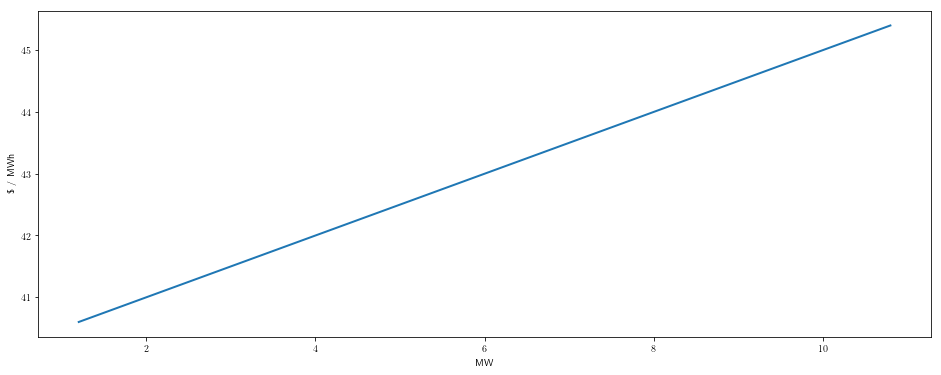

In [17]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('\$ / MWh')

## Prescient DOPF

In [18]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_energy_price = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=0, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator",
                       len_interval = len_interval)
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      energy_final = final_storage,
                     len_interval = len_interval,
                     final_energy_price = final_energy_price)
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    my_network = Group([wind_gen, gas_gen, storage, out], [net])
    my_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, final_energy_price, my_network

In [10]:
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, final_energy_price, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(p_wind[sim_start_time:sim_end_time]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(0.)

cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.709e+05  -4.191e+06  +6e+06  6e-02  6e-02  1e+00  2e+02    ---    ---    1  1  - |  -  - 
 1  +3.697e+05  -3.394e+06  +5e+06  5e-02  4e-02  6e+01  2e+02  0.5310  5e-01   1  1  2 |  0  0
 2  +2.486e+05  -8.609e+05  +1e+06  1e-02  1e-02  4e+01  5e+01  0.8215  2e-01   1  1  1 |  0  0
 3  +2.397e+05  -8.206e+05  +1e+06  1e-02  1e-02  4e+01  5e+01  0.1629  7e-01   2  2  2 |  0  0
 4  +1.837e+05  -4.951e+05  +8e+05  8e-03  7e-03  3e+01  3e+01  0.7613  5e-01   1  2  1 |  0  0
 5  +1.432e+05  -1.769e+05  +4e+05  4e-03  3e-03  2e+01  1e+01  0.6270  2e-01   1  1  1 |  0  0
 6  +1.442e+05  -1.528e+05  +4e+05  3e-03  3e-03  1e+01  1e+01  0.2117  7e-01   1  1  1 |  0  0
 7  +1.284e+05  +1.767e+04  +1e+05  1e-03  1e-03  5e+00  5e+00  0.7543  2e-01   1  1  1 |  0  0
 8  +1.284e+05  +2.267e+04  +1e+05  1e-03  1e-

In [19]:
def print_and_plot_stats(wind_power_avail, wind_power_used, gas_power, output, cost):
    assert len(output) == len(wind_power_avail)
    assert len(output) == len(wind_power_used)
    assert len(output) == len(gas_power)

    plt.figure(figsize=(9,3.5))
    plt.subplot2grid((10,1), (0,0), rowspan=9)
    plt.plot(wind_power_avail.index, wind_power_avail.values, label='avail.', alpha=.8)
    pd.Series(data = wind_power_used, 
              index = wind_power_avail.index).plot(label='used', alpha=.8)
    #output.plot(label='target', style='--', color='k', alpha=.8)
    plt.legend(loc='lower left')
    plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
    plt.ylabel('Power (MW)')
    plt.xlabel('time')
    #plt.gcf().autofmt_xdate()
    plt.savefig('wind_curtailment.pdf')

    total_output = sum(output)/len(output) 
    total_wind_power_avail = sum(wind_power_avail)/len(output)
    total_gas_gen = sum(gas_power)/len(output)

    print('(Values are daily averages.)\n')
    print('Energy sold:\t\t%.2f MWh\nWind energy avail.:\t%.2f MWh\nGas gener. output:\t%.2f MWh\nWind energy used:\t%.2f MWh\nWind energy lost:\t%.2f MWh' % (
        24*total_output,
        24*total_wind_power_avail,
        24*total_gas_gen,
        24*np.mean(wind_power_used),
        24*(total_wind_power_avail - np.mean(wind_power_used))
    ))

    print('\nEnergy sold (at $80/MWh):    $%.2f' % (24 * total_output *80))
    print('Cost of gas generated energy:  $%.2f' % (24 * cost / (len(output))))

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	22.96 MWh
Wind energy used:	169.04 MWh
Wind energy lost:	33.32 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $953.74


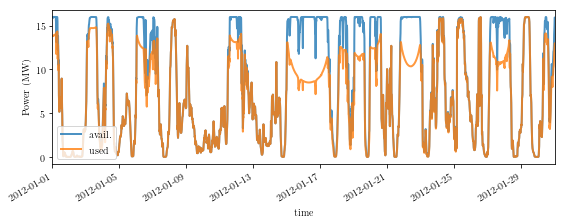

In [12]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]


print_and_plot_stats(wind_power_avail = p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -dopf_network.results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -dopf_network.results.power[(gas_gen,0)], 
                     output = target_output[:T], 
                     cost = cost_dopf)

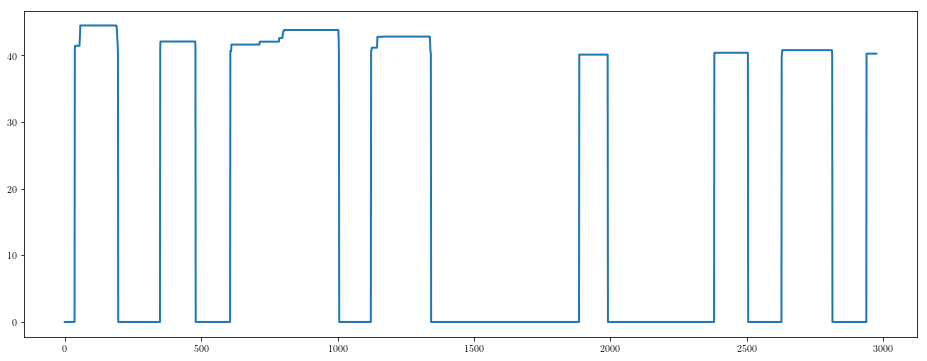

In [13]:
plt.plot(list(dopf_network.results.price.values())[0].flatten());
#p_wind[sim_start_time:sim_end_time].index

In [20]:
import pandas as pd
#high_level = ['prescient', 'MPC, exact pred.', 'MPC, uncert. pred.']
#low_level = ['avg.', 'st. dev.']
flows = pd.DataFrame()#columns=pd.MultiIndex.from_product([high_level, low_level], names=['', '']))
for (device, terminal) in dopf_network.results.power.keys():
    #print(np.mean(dopf_network.results.power[(device, terminal)]))
    flows.loc[device.name, 'prescient'] = np.mean(dopf_network.results.power[(device, terminal)])
    #flows.loc[device.name, ('prescient','st. dev.')] = np.std(dopf_network.results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))


prices = pd.DataFrame()
for net in dopf_network.results.price.keys():
    prices.loc[net.name, 'prescient'] = np.mean(dopf_network.results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.2f' % x))


payments = pd.DataFrame()
for (device, terminal) in dopf_network.results.payments.keys():
    payments.loc[device.name, 'prescient'] = np.sum(dopf_network.results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))



NameError: name 'dopf_network' is not defined

In [19]:
def plot(results, target_output, energy_stored, methodname):
    ax = results.plot(figsize=(9,3.5), index=target_output.index)
    plt.subplots_adjust(hspace=0.075)
    ax[0].set_ylabel('power (MW)')
    ax[0].set_xlim(['01-01-2012', '01-31-2012'])
    ax[0].legend(['gen.', 'batt.', 'target', 'wind'], loc='lower left')
    ax[0].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")
    ax[1].clear() 
    ax[1].plot(target_output.index, energy_stored)
    ax[1].set_ylabel('Energy (MWh)')
    ax[1].set_xlim(['01-01-2012', '01-31-2012'])
    ax[1].set_ylim([0, 50])
    plt.xlabel('time')
    plt.savefig(graphdir+'wind_%s_results.pdf'%methodname)
    
    prices = list(results.price.values())[0].flatten()
    plt.figure(figsize=(9,3.5))
    plt.plot(target_output.index, prices)
    plt.ylabel('net price (\$)')
    


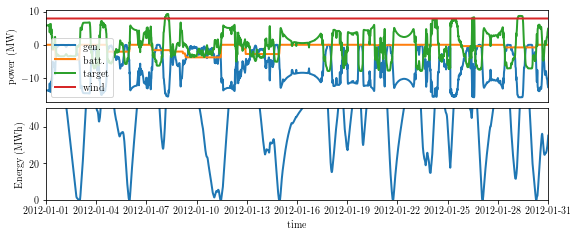

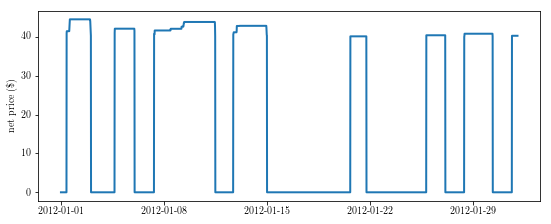

In [12]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

plot(dopf_network.results, baseline[sim_start_time:sim_end_time], storage.energy.value, 'dopf')

## Prescient MPC 

In [15]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, \
initial_storage_MPC, final_storage_MPC, \
final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [02:14<00:00, 22.08it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.04 MWh
Wind energy used:	167.81 MWh
Wind energy lost:	34.55 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1044.48


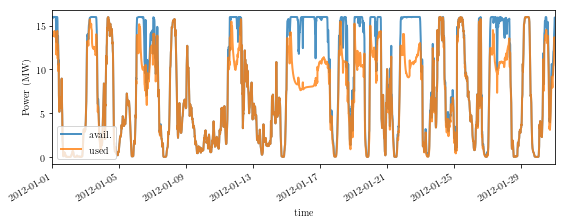

In [16]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

In [60]:
#plt.plot(list(prescient_MPC_results.price.values())[0].flatten())
#p_wind[sim_start_time:sim_end_time].index

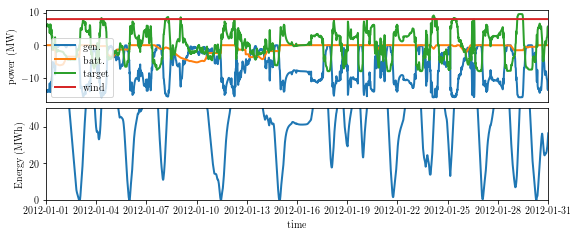

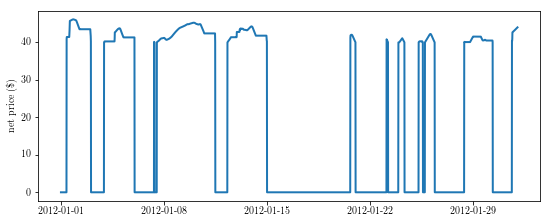

In [61]:
plot(prescient_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'presc_mpc')

In [62]:
for (device, terminal) in prescient_MPC_results.power.keys():
    flows.loc[device.name, 'exact MPC'] = np.mean(prescient_MPC_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, exact pred.','st. dev.')] = np.std(prescient_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))

for net in prescient_MPC_results.price.keys():
    prices.loc[net.name, 'exact MPC'] = np.mean(prescient_MPC_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.2f' % x))

for (device, terminal) in prescient_MPC_results.payments.keys():
    payments.loc[device.name, 'exact MPC'] = np.sum(prescient_MPC_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Wind generator &    -7.04MW &    -6.99MW \\
Gas generator  &    -0.96MW &    -1.04MW \\
Storage        &    -0.00MW &     0.04MW \\
Target output  &     8.00MW &     8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Net &     \$19.24 &     \$19.85 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Wind generator &    \$-52366 &    \$-67062 \\
Gas generator  &    \$-30658 &    \$-33715 \\
Storage        &    \$-31470 &    \$-17357 \\
Target output  &    \$114495 &    \$118133 \\
\bottomrule
\end{tabular}



## MPC with baseline and residual AR

In [21]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(wind_power_min, pred)
    pred = np.minimum(wind_power_max, pred)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    val_to_assign = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
    print(type(val_to_assign))
    print(val_to_assign.shape)
    wind_power_available_MPC.value = val_to_assign
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    


In [22]:
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

  0%|          | 4/2976 [00:00<05:05,  9.74it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  0%|          | 10/2976 [00:00<03:34, 13.82it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|          | 15/2976 [00:00<02:54, 16.94it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|          | 21/2976 [00:01<02:30, 19.63it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|          | 24/2976 [00:01<02:26, 20.15it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|          | 30/2976 [00:01<02:26, 20.14it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|          | 33/2976 [00:01<02:28, 19.78it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|▏         | 39/2976 [00:01<02:41, 18.16it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  1%|▏         | 43/2976 [00:02<02:44, 17.83it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  2%|▏         | 47/2976 [00:02<02:39, 18.35it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  2%|▏         | 51/2976 [00:02<02:33, 19.11it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  2%|▏         | 57/2976 [00:02<02:21, 20.63it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


  2%|▏         | 63/2976 [00:03<02:20, 20.75it/s]

<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(96, 1)


KeyboardInterrupt: 

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	40.53 MWh
Wind energy used:	150.96 MWh
Wind energy lost:	51.40 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1703.51


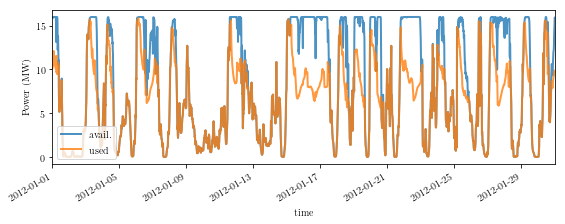

In [19]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)

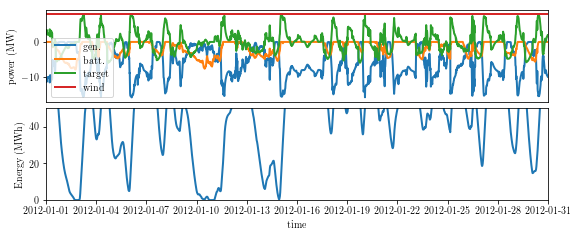

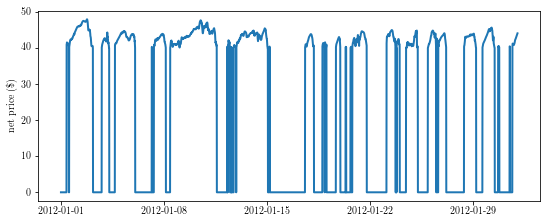

In [22]:
plot(AR_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'AR_mpc')

In [20]:
for (device, terminal) in AR_MPC_results.power.keys():
    flows.loc[device.name, 'uncert. MPC'] = np.mean(AR_MPC_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, uncert. pred.','st. dev.')] = np.std(AR_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.0fMW' % x))

for net in AR_MPC_results.price.keys():
    prices.loc[net.name, 'uncert. MPC'] = np.mean(AR_MPC_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

for (device, terminal) in AR_MPC_results.payments.keys():
    payments.loc[device.name, 'uncert. MPC'] = np.sum(AR_MPC_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrr}
\toprule
{} &  prescient &  uncert. MPC \\
\midrule
Wind generator &       -7MW &         -6MW \\
Gas generator  &       -1MW &         -2MW \\
Storage        &       -0MW &         -0MW \\
Target output  &        8MW &          8MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  uncert. MPC \\
\midrule
Net &        \$19 &          \$24 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  uncert. MPC \\
\midrule
Wind generator &    \$-52366 &      \$-63732 \\
Gas generator  &    \$-30658 &      \$-55355 \\
Storage        &    \$-31470 &      \$-24326 \\
Target output  &    \$114495 &      \$143413 \\
\bottomrule
\end{tabular}



### Diagnostic 

In [24]:
# t = sim_start_time

# past = p_wind[t-intervals_per_day:t]
# future = p_wind[t:t+intervals_per_day]

# past_baseline = baseline[t-intervals_per_day:t]
# fut_baseline = baseline[t:t+intervals_per_day]

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(p_wind, baseline, autoreg_residual_params, t, intervals_per_day, intervals_per_day)

# (pred - fut_baseline).plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred).plot()

## Robust MPC 

In [13]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    


In [ ]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.07 MWh
Wind energy used:	166.82 MWh
Wind energy lost:	35.54 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1071.64


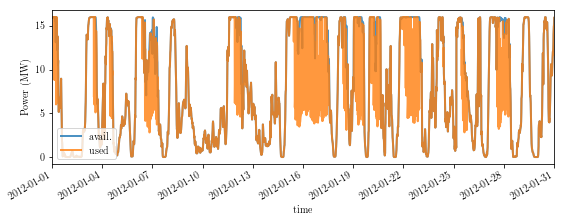

In [29]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

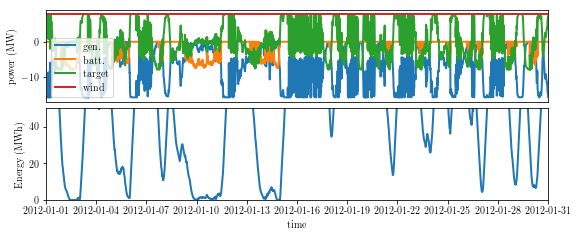

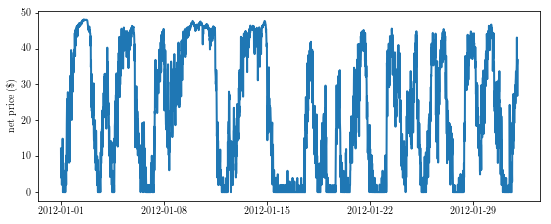

In [30]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')

In [31]:
for (device, terminal) in MPC_robust_results.power.keys():
    flows.loc[device.name, 'robust MPC'] = np.mean(MPC_robust_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, uncert. pred.','st. dev.')] = np.std(AR_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))

for net in MPC_robust_results.price.keys():
    prices.loc[net.name, 'robust MPC'] = np.mean(MPC_robust_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

for (device, terminal) in MPC_robust_results.payments.keys():
    payments.loc[device.name, 'robust MPC'] = np.sum(MPC_robust_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    -7.04MW &      -6.29MW &     -6.95MW \\
Gas generator  &    -0.96MW &      -1.69MW &     -1.04MW \\
Storage        &    -0.00MW &      -0.02MW &     -0.00MW \\
Target output  &     8.00MW &       8.00MW &      8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Net &        \$19 &          \$24 &         \$22 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    \$-52366 &      \$-63703 &     \$-73517 \\
Gas generator  &    \$-30658 &      \$-55410 &     \$-35351 \\
Storage        &    \$-31470 &      \$-24309 &     \$-22649 \\
Target output  &    \$114495 &      \$143422 &     \$131517 \\
\bottomrule
\end{tabular}



## Robust MPC using Gaussian Process for Scenarios

In [21]:
# Load the GP model
import pickle as pkl
with open("dim96_lenScale14_trSamps10000_GP.pickle", "rb") as f:
    gp = pkl.load(f)

In [22]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    ##### ORIGINAL CODE #####
#     scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
#                            np.random.multivariate_normal(predict_wind(p_wind, baseline, 
#                             autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
#                              sigma_residual_errors, K)[:,:-1]])
    ##### ORIGINAL CODE #####
    
    # This call to np.random.multivariate_normal is doing the following:
    # Getting a prediction of the wind T_MPC steps into the future and using that as the mean of the distr
    # Using the sigma_residual_errors as the cov
    # The first entry is known, and then it gets N-1 samples from the distribution
    # Sampling from that distr
    
    # That means all I need to do is get the SAME prediction, and then add samples from my GP distribution
    # to copies of the prediction instead
    
    #### Logan's GP code ####
    # First, get the forecast for the next T_MPC intervals
    forecast = predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)
    # Then, combine that with data from the past T_MPC intervals and then dice it into a matrix
    # where each row is the past T_MPC values (real or predicted) leading up to a point. This will
    # be the input to the GP
    eval_data = np.concatenate((p_wind[sim_start_time+t-T_MPC:sim_start_time+t], forecast))
    N = eval_data.shape[0]
    
    gp_input = eval_data[indexer]
#     gp_input = np.zeros((N - T_MPC, T_MPC))
#     for i in range(gp_input.shape[0]):
#         gp_input[i,:] = eval_data[i:(i+T_MPC)]
        
    # Get some samples of residuals from the GP
    samps = gp.sample_y(gp_input, K)
    samps = samps.T
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T, 
                          samps[:,:-1]])
    
    
#     plt.figure(figsize=(19,4))
#     for k in range(K):
#         plt.plot(samps[:,k], alpha=0.4)
#     plt.show()
    
#     print("__________________Iteration__________________")
#     print(scenarios.shape)
#     print(forecast.shape)
#     print(forecast)
#     print()
#     print(scenarios[0,:].shape)
#     plt.figure(figsize=(19,4))
#     for i in range(K):
#         print(np.array(scenarios[i,:]).squeeze().shape)
#         plt.plot(np.array(scenarios[i,:]).squeeze())
#     plt.show()
    
    #### Logan's GP code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    


In [23]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [1:13:42<00:00,  1.05s/it]  


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	41.31 MWh
Wind energy used:	150.34 MWh
Wind energy lost:	52.02 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1735.98


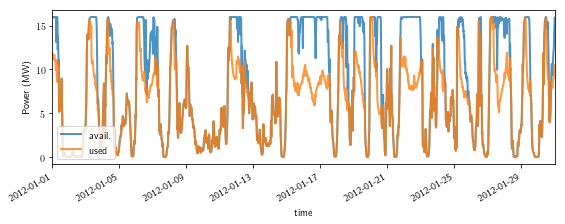

In [24]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

/Users/loganspear/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


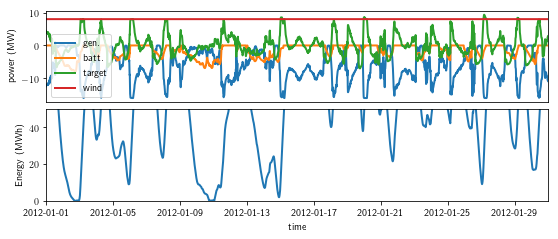

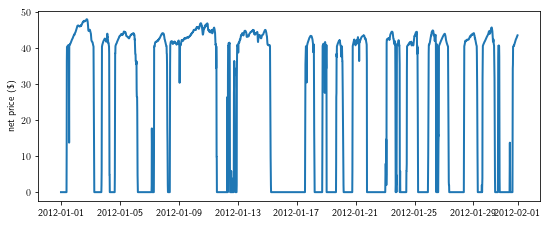

In [20]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')

In [31]:
for (device, terminal) in MPC_robust_results.power.keys():
    flows.loc[device.name, 'robust MPC'] = np.mean(MPC_robust_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, uncert. pred.','st. dev.')] = np.std(AR_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))

for net in MPC_robust_results.price.keys():
    prices.loc[net.name, 'robust MPC'] = np.mean(MPC_robust_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

for (device, terminal) in MPC_robust_results.payments.keys():
    payments.loc[device.name, 'robust MPC'] = np.sum(MPC_robust_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    -7.04MW &      -6.29MW &     -6.95MW \\
Gas generator  &    -0.96MW &      -1.69MW &     -1.04MW \\
Storage        &    -0.00MW &      -0.02MW &     -0.00MW \\
Target output  &     8.00MW &       8.00MW &      8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Net &        \$19 &          \$24 &         \$22 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    \$-52366 &      \$-63703 &     \$-73517 \\
Gas generator  &    \$-30658 &      \$-55410 &     \$-35351 \\
Storage        &    \$-31470 &      \$-24309 &     \$-22649 \\
Target output  &    \$114495 &      \$143422 &     \$131517 \\
\bottomrule
\end{tabular}

